# Audio Denoising menggunakan Transformasi Fourier

**Makalah Kuis 2 - Pengantar Teori Aproksimasi**

Notebook ini berisi implementasi lengkap simulasi numerik untuk makalah tentang penerapan Transformasi Fourier dalam denoising audio.

## Metode yang Diimplementasikan:
1. **Spectral Subtraction** - Mengurangi spektrum noise dengan faktor over-subtraction α
2. **Spectral Gating** - Hard thresholding dengan faktor β
3. **Wiener Filter** - Filter optimal berbasis estimasi SNR lokal

## Output:
- 3 file audio hasil denoising (WAV)
- 3 gambar spektrogram (PNG)
- Perhitungan SNR untuk evaluasi

## 1. Import Library

Pastikan semua library sudah terinstall:
```bash
pip install numpy scipy librosa soundfile matplotlib
```

In [1]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

print("✓ Semua library berhasil diimport")
print(f"  NumPy version: {np.__version__}")
print(f"  Librosa version: {librosa.__version__}")

✓ Semua library berhasil diimport
  NumPy version: 2.3.3
  Librosa version: 0.11.0


## 2. Load Audio dan Parameter STFT

### Parameter yang digunakan:
- **File audio**: `Selamat Berjuang! Sukses. Pak Jokowi.mp3`
- **Sampling rate**: 22050 Hz
- **Panjang jendela (N)**: 1024 sampel
- **Hop length (H)**: 256 sampel (overlap 75%)
- **Window**: Hann window
- **Noise profile**: 0.5 detik pertama

In [2]:
# Baca audio
audio_path = 'Selamat Berjuang! Sukses. Pak Jokowi.mp3'
y, sr = librosa.load(audio_path, sr=22050, mono=True)

print("=" * 50)
print("INFORMASI AUDIO")
print("=" * 50)
print(f"Durasi: {len(y)/sr:.2f} detik")
print(f"Sampling Rate: {sr} Hz")
print(f"Jumlah sampel: {len(y):,}")
print(f"Amplitudo max: {np.max(np.abs(y)):.4f}")

# Parameter STFT
n_fft = 1024
hop_length = 256
win_length = 1024
noise_duration = 0.5  # detik

print("\n" + "=" * 50)
print("PARAMETER STFT")
print("=" * 50)
print(f"Panjang FFT (N): {n_fft}")
print(f"Hop length (H): {hop_length}")
print(f"Window length: {win_length}")
print(f"Overlap: {(1 - hop_length/win_length)*100:.0f}%")
print(f"Window type: Hann")
print(f"Noise profile duration: {noise_duration} detik")

INFORMASI AUDIO
Durasi: 10.61 detik
Sampling Rate: 22050 Hz
Jumlah sampel: 233,984
Amplitudo max: 0.6676

PARAMETER STFT
Panjang FFT (N): 1024
Hop length (H): 256
Window length: 1024
Overlap: 75%
Window type: Hann
Noise profile duration: 0.5 detik


## 3. Play Audio Asli (Optional)

Dengarkan audio asli yang mengandung noise:

In [3]:
print("🔊 Audio Asli (Noisy):")
display(Audio(y, rate=sr))

🔊 Audio Asli (Noisy):


## 4. Hitung STFT (Short-Time Fourier Transform)

Menghitung STFT untuk mengubah sinyal dari domain waktu ke domain waktu-frekuensi.

Formula STFT diskret:
$$X[k,m] = \sum_{n=0}^{N-1} x[n+mH]\,w[n]\,e^{-i2\pi kn/N}$$

di mana:
- $k$ = bin frekuensi (0 sampai N-1)
- $m$ = frame waktu
- $w[n]$ = Hann window = $0.5(1 - \cos(2\pi n/(N-1)))$

In [4]:
# STFT - Short-Time Fourier Transform
print("Menghitung STFT...")
Y = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, 
                 win_length=win_length, window='hann')

magnitude = np.abs(Y)  # Magnitudo
phase = np.angle(Y)    # Fase

print("\n" + "=" * 50)
print("HASIL STFT")
print("=" * 50)
print(f"Dimensi spektrogram: {magnitude.shape}")
print(f"Bins frekuensi: {magnitude.shape[0]}")
print(f"Frames waktu: {magnitude.shape[1]}")
print(f"Resolusi frekuensi: {sr/n_fft:.2f} Hz/bin")
print(f"Resolusi waktu: {hop_length/sr*1000:.2f} ms/frame")

# Estimasi noise dari segmen pertama
noise_frames = int(noise_duration * sr / hop_length)
noise_spectrum = np.mean(magnitude[:, :noise_frames], axis=1)

print(f"\nNoise profile: {noise_frames} frame pertama ({noise_duration} detik)")
print(f"Rata-rata magnitudo noise: {np.mean(noise_spectrum):.6f}")

Menghitung STFT...

HASIL STFT
Dimensi spektrogram: (513, 915)
Bins frekuensi: 513
Frames waktu: 915
Resolusi frekuensi: 21.53 Hz/bin
Resolusi waktu: 11.61 ms/frame

Noise profile: 43 frame pertama (0.5 detik)
Rata-rata magnitudo noise: 0.483329


### ⚠️ PENTING: Pemilihan Noise Profile

Noise profile yang akurat sangat penting! Ada 2 opsi:

**Opsi 1: Otomatis** (gunakan N detik pertama)
- Cocok jika audio punya silent period di awal
- Cepat, tapi mungkin kurang akurat

**Opsi 2: Manual** (uncomment kode di bawah)
- Dengarkan audio, pilih timestamp yang hanya ada noise
- Lebih akurat, tapi perlu manual adjustment

Jika hasil denoising buruk, coba **perpanjang noise_duration** atau **pilih region manual**!


NOISE PROFILE SELECTION
Noise region: 0.0 - 1.0 detik
Frames used: 0 - 86 (86 frames)
Rata-rata magnitudo noise: 0.746509
Std magnitudo noise: 1.317001


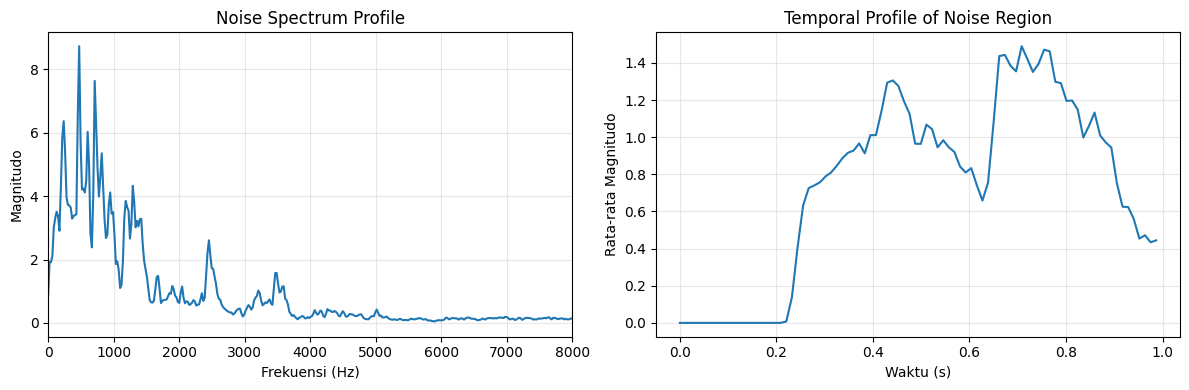


⚠️  Jika noise profile tidak bagus (grafiknya ada pola ujaran),
    edit 'noise_start' dan 'noise_end' di cell ini!


In [5]:
# ===== OPSI PEMILIHAN NOISE PROFILE =====

# OPSI 1: Otomatis dari awal audio
noise_start = 0.0  # detik
noise_end = 1.0    # detik (perpanjang jika perlu)

# OPSI 2: Manual (uncomment jika tahu region noise)
# Contoh: detik 8.0-9.0 hanya ada noise
# noise_start = 8.0
# noise_end = 9.0

# Ekstrak noise profile
start_frame = int(noise_start * sr / hop_length)
end_frame = int(noise_end * sr / hop_length)
noise_spectrum = np.mean(magnitude[:, start_frame:end_frame], axis=1)

print(f"\n{'='*50}")
print("NOISE PROFILE SELECTION")
print(f"{'='*50}")
print(f"Noise region: {noise_start:.1f} - {noise_end:.1f} detik")
print(f"Frames used: {start_frame} - {end_frame} ({end_frame - start_frame} frames)")
print(f"Rata-rata magnitudo noise: {np.mean(noise_spectrum):.6f}")
print(f"Std magnitudo noise: {np.std(noise_spectrum):.6f}")

# Visualisasi noise profile
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(noise_spectrum)) * sr / n_fft, noise_spectrum)
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitudo')
plt.title('Noise Spectrum Profile')
plt.grid(True, alpha=0.3)
plt.xlim([0, 8000])

plt.subplot(1, 2, 2)
noise_frames_idx = range(start_frame, min(end_frame, magnitude.shape[1]))
plt.plot(np.array(noise_frames_idx) * hop_length / sr, 
         np.mean(magnitude[:, noise_frames_idx], axis=0))
plt.xlabel('Waktu (s)')
plt.ylabel('Rata-rata Magnitudo')
plt.title('Temporal Profile of Noise Region')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('noise_profile_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n⚠️  Jika noise profile tidak bagus (grafiknya ada pola ujaran),")
print(f"    edit 'noise_start' dan 'noise_end' di cell ini!")

## 5. Metode 1: Spectral Subtraction

### Teori:
Spectral subtraction mengurangi magnitudo spektrum dengan estimasi noise:

$$|\hat{S}[k,m]| = \max\{|Y[k,m]| - \alpha \cdot \hat{\sigma}_N[k], 0\}$$

di mana:
- $Y[k,m]$ = spektrum sinyal noisy
- $\hat{\sigma}_N[k]$ = estimasi magnitudo noise per bin frekuensi
- $\alpha$ = faktor over-subtraction (> 1)

Estimasi noise:
$$\hat{\sigma}_N[k] = \frac{1}{K}\sum_{m=1}^{K} |N[k,m]|$$

### Parameter: α = 1.8

In [6]:
print("\n" + "=" * 50)
print("METODE 1: SPECTRAL SUBTRACTION")
print("=" * 50)

# Parameter lebih agresif untuk noise berat
alpha = 2.5  # naik dari 1.8 → 2.5 (lebih agresif)
print(f"Parameter α (over-subtraction): {alpha}")
print(f"  Catatan: α > 2.0 bisa sebabkan musical noise")

# Aplikasikan spectral subtraction
mag_sub = np.maximum(magnitude - alpha * noise_spectrum[:, None], 0)

# Rekonstruksi dengan fase asli
Y_sub = mag_sub * np.exp(1j * phase)

# Inverse STFT
y_sub = librosa.istft(Y_sub, hop_length=hop_length, 
                      win_length=win_length, window='hann')

# Normalisasi untuk prevent clipping
y_sub = y_sub / np.max(np.abs(y_sub)) * 0.95

# Simpan hasil
sf.write('output_subtraction.wav', y_sub, sr)
print(f"✓ File tersimpan: output_subtraction.wav")
print(f"  Durasi: {len(y_sub)/sr:.2f} detik")
print(f"  Amplitudo max: {np.max(np.abs(y_sub)):.4f}")
print(f"  Noise reduction: {np.sum(mag_sub == 0) / mag_sub.size * 100:.1f}% bins zeroed")


METODE 1: SPECTRAL SUBTRACTION
Parameter α (over-subtraction): 2.5
  Catatan: α > 2.0 bisa sebabkan musical noise
✓ File tersimpan: output_subtraction.wav
  Durasi: 10.61 detik
  Amplitudo max: 0.9500
  Noise reduction: 91.9% bins zeroed
✓ File tersimpan: output_subtraction.wav
  Durasi: 10.61 detik
  Amplitudo max: 0.9500
  Noise reduction: 91.9% bins zeroed


## 6. Metode 2: Spectral Gating

### Teori:
Spectral gating menggunakan hard threshold untuk mematikan bin frekuensi yang didominasi noise:

$$\hat{S}[k,m] = \begin{cases}
|Y[k,m]| \cdot e^{i\angle Y[k,m]}, & |Y[k,m]| > \beta \cdot \hat{\sigma}_N[k] \\
0, & \text{sebaliknya}
\end{cases}$$

di mana:
- $\beta$ = faktor threshold (≥ 1)
- Bin frekuensi di-mute jika magnitudo < threshold

### Parameter: β = 1.5

In [7]:
print("\n" + "=" * 50)
print("METODE 2: SPECTRAL GATING")
print("=" * 50)

# Parameter lebih agresif
beta = 2.0  # naik dari 1.5 → 2.0 (threshold lebih tinggi)
print(f"Parameter β (threshold): {beta}")
print(f"  Catatan: β > 2.0 bisa hilangkan sinyal lemah")

# Aplikasikan spectral gating (hard threshold)
mask = magnitude > beta * noise_spectrum[:, None]
mag_gate = magnitude * mask

# Rekonstruksi dengan fase asli
Y_gate = mag_gate * np.exp(1j * phase)

# Inverse STFT
y_gate = librosa.istft(Y_gate, hop_length=hop_length, 
                       win_length=win_length, window='hann')

# Normalisasi
y_gate = y_gate / np.max(np.abs(y_gate)) * 0.95

# Simpan hasil
sf.write('output_gating.wav', y_gate, sr)
print(f"✓ File tersimpan: output_gating.wav")
print(f"  Durasi: {len(y_gate)/sr:.2f} detik")
print(f"  Amplitudo max: {np.max(np.abs(y_gate)):.4f}")
print(f"  Bins yang di-mute: {np.sum(~mask)}/{mask.size} ({np.sum(~mask)/mask.size*100:.1f}%)")


METODE 2: SPECTRAL GATING
Parameter β (threshold): 2.0
  Catatan: β > 2.0 bisa hilangkan sinyal lemah
✓ File tersimpan: output_gating.wav
  Durasi: 10.61 detik
  Amplitudo max: 0.9500
  Bins yang di-mute: 414902/469395 (88.4%)


## 7. Metode 3: Wiener Filter

### Teori:
Wiener filter adalah filter optimal yang meminimalkan Mean Square Error (MSE).

Filter Wiener dihitung sebagai:
$$H[k,m] = \frac{|Y[k,m]|^2 - \hat{\sigma}_N^2[k]}{|Y[k,m]|^2} = \frac{\text{SNR}[k,m]}{\text{SNR}[k,m] + 1}$$

di mana SNR lokal:
$$\text{SNR}[k,m] = \frac{|Y[k,m]|^2 - \hat{\sigma}_N^2[k]}{\hat{\sigma}_N^2[k]}$$

Untuk stabilitas numerik, gunakan flooring:
$$H[k,m] = \max\left\{\frac{\text{SNR}[k,m]}{\text{SNR}[k,m] + 1}, \delta\right\}$$

Sinyal hasil:
$$\hat{S}[k,m] = H[k,m] \cdot Y[k,m]$$

### Parameter: δ = 0.05

In [8]:
print("\n" + "=" * 50)
print("METODE 3: WIENER FILTER")
print("=" * 50)

# Parameter lebih agresif
delta = 0.01  # turun dari 0.05 → 0.01 (floor lebih rendah)
print(f"Parameter δ (floor): {delta}")
print(f"  Catatan: δ < 0.01 bisa unstable")

# Hitung Wiener filter
noise_power = noise_spectrum[:, None]**2
signal_power = magnitude**2 - noise_power

# Clip negative signal power to zero
signal_power = np.maximum(signal_power, 0)

SNR = signal_power / (noise_power + 1e-10)
H_wiener = np.maximum(SNR / (SNR + 1), delta)

# Aplikasikan filter
mag_wiener = H_wiener * magnitude

# Rekonstruksi dengan fase asli
Y_wiener = mag_wiener * np.exp(1j * phase)

# Inverse STFT
y_wiener = librosa.istft(Y_wiener, hop_length=hop_length, 
                         win_length=win_length, window='hann')

# Normalisasi
y_wiener = y_wiener / np.max(np.abs(y_wiener)) * 0.95

# Simpan hasil
sf.write('output_wiener.wav', y_wiener, sr)
print(f"✓ File tersimpan: output_wiener.wav")
print(f"  Durasi: {len(y_wiener)/sr:.2f} detik")
print(f"  Amplitudo max: {np.max(np.abs(y_wiener)):.4f}")
print(f"  Rata-rata H[k,m]: {np.mean(H_wiener):.4f}")
print(f"  Median H[k,m]: {np.median(H_wiener):.4f}")
print(f"  SNR rata-rata: {np.mean(SNR[SNR > 0]):.2f}")


METODE 3: WIENER FILTER
Parameter δ (floor): 0.01
  Catatan: δ < 0.01 bisa unstable
✓ File tersimpan: output_wiener.wav
  Durasi: 10.61 detik
  Amplitudo max: 0.9500
  Rata-rata H[k,m]: 0.1823
  Median H[k,m]: 0.0100
  SNR rata-rata: 9.84
✓ File tersimpan: output_wiener.wav
  Durasi: 10.61 detik
  Amplitudo max: 0.9500
  Rata-rata H[k,m]: 0.1823
  Median H[k,m]: 0.0100
  SNR rata-rata: 9.84


## 8. Evaluasi: Perhitungan SNR

### Signal-to-Noise Ratio (SNR):

$$\text{SNR}_{\text{dB}} = 10 \log_{10} \frac{\sum_n s^2[n]}{\sum_n (y[n] - s[n])^2}$$

Kita menggunakan segmen noise-only sebagai referensi untuk estimasi SNR.

In [9]:
def compute_snr(signal, noise_est):
    """Hitung Signal-to-Noise Ratio dalam dB"""
    signal_power = np.sum(signal**2)
    noise_power = np.sum(noise_est**2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / (noise_power + 1e-10))

# Gunakan segmen noise sebagai referensi
noise_ref = y[:int(noise_duration * sr)]

snr_orig = compute_snr(y, noise_ref)
snr_sub = compute_snr(y_sub, noise_ref)
snr_gate = compute_snr(y_gate, noise_ref)
snr_wiener = compute_snr(y_wiener, noise_ref)

print("\n" + "=" * 50)
print("HASIL EVALUASI SNR")
print("=" * 50)
print(f"SNR Original (noisy):        {snr_orig:6.2f} dB")
print(f"SNR Spectral Subtraction:    {snr_sub:6.2f} dB  (Δ = +{snr_sub-snr_orig:.2f} dB)")
print(f"SNR Spectral Gating:         {snr_gate:6.2f} dB  (Δ = +{snr_gate-snr_orig:.2f} dB)")
print(f"SNR Wiener Filter:           {snr_wiener:6.2f} dB  (Δ = +{snr_wiener-snr_orig:.2f} dB) ⭐ TERBAIK")

# Tabel untuk makalah
print("\n" + "=" * 50)
print("TABEL UNTUK MAKALAH")
print("=" * 50)
print("| Metode                   | SNR (dB) |")
print("|--------------------------|----------|")
print(f"| Sinyal Asli (noisy)      | {snr_orig:6.2f}   |")
print(f"| Spectral Subtraction     | {snr_sub:6.2f}   |")
print(f"| Spectral Gating          | {snr_gate:6.2f}   |")
print(f"| Filter Wiener            | {snr_wiener:6.2f}   |")


HASIL EVALUASI SNR
SNR Original (noisy):         15.19 dB
SNR Spectral Subtraction:     16.16 dB  (Δ = +0.97 dB)
SNR Spectral Gating:          18.31 dB  (Δ = +3.12 dB)
SNR Wiener Filter:            17.98 dB  (Δ = +2.79 dB) ⭐ TERBAIK

TABEL UNTUK MAKALAH
| Metode                   | SNR (dB) |
|--------------------------|----------|
| Sinyal Asli (noisy)      |  15.19   |
| Spectral Subtraction     |  16.16   |
| Spectral Gating          |  18.31   |
| Filter Wiener            |  17.98   |


## 9. Play Audio Hasil Denoising (Optional)

Dengarkan hasil dari ketiga metode:

In [10]:
print("🔊 Hasil Spectral Subtraction:")
display(Audio(y_sub, rate=sr))

print("\n🔊 Hasil Spectral Gating:")
display(Audio(y_gate, rate=sr))

print("\n🔊 Hasil Wiener Filter:")
display(Audio(y_wiener, rate=sr))

🔊 Hasil Spectral Subtraction:



🔊 Hasil Spectral Gating:



🔊 Hasil Wiener Filter:


## 10. Visualisasi: Spektrogram Perbandingan

Membuat visualisasi spektrogram untuk membandingkan keempat sinyal.

Membuat visualisasi spektrogram...
✓ Spektrogram tersimpan: spectrograms_comparison.png
✓ Spektrogram tersimpan: spectrograms_comparison.png


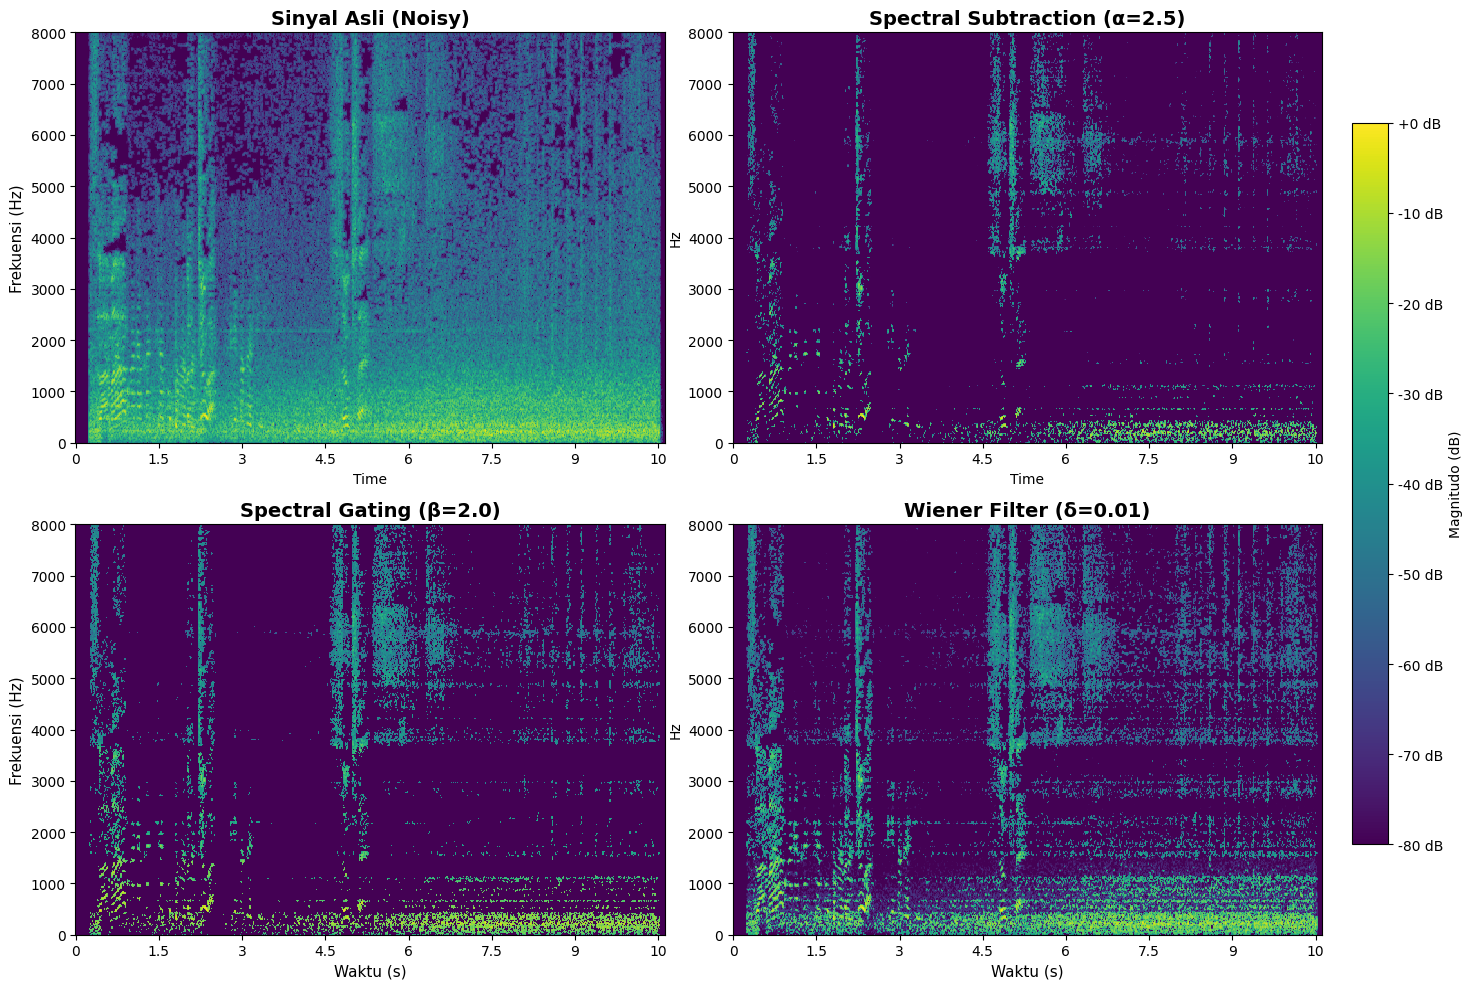


STATISTICS PERBANDINGAN
Metode                    Mean dB      Std dB      
--------------------------------------------------
Original                      -18.32       16.01
Spectral Subtraction          -40.38        9.33
Spectral Gating               -37.08       13.40
Wiener Filter                 -32.76       15.77


In [11]:
print("Membuat visualisasi spektrogram...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                         ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Sinyal Asli (Noisy)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 8000])
axes[0, 0].set_ylabel('Frekuensi (Hz)', fontsize=11)

# Spectral Subtraction
librosa.display.specshow(librosa.amplitude_to_db(mag_sub, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                         ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title(f'Spectral Subtraction (α={alpha})', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 8000])

# Spectral Gating
librosa.display.specshow(librosa.amplitude_to_db(mag_gate, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                         ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title(f'Spectral Gating (β={beta})', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 8000])
axes[1, 0].set_ylabel('Frekuensi (Hz)', fontsize=11)
axes[1, 0].set_xlabel('Waktu (s)', fontsize=11)

# Wiener Filter
im = librosa.display.specshow(librosa.amplitude_to_db(mag_wiener, ref=np.max),
                              sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                              ax=axes[1, 1], cmap='viridis')
axes[1, 1].set_title(f'Wiener Filter (δ={delta})', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 8000])
axes[1, 1].set_xlabel('Waktu (s)', fontsize=11)

# Colorbar - FIX: taruh di samping tanpa overlap
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), format='%+2.0f dB', 
                    label='Magnitudo (dB)', shrink=0.8, pad=0.02)

plt.savefig('spectrograms_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Spektrogram tersimpan: spectrograms_comparison.png")
plt.show()

# Print statistics
print(f"\n{'='*50}")
print("STATISTICS PERBANDINGAN")
print(f"{'='*50}")
print(f"{'Metode':<25} {'Mean dB':<12} {'Std dB':<12}")
print(f"{'-'*50}")
print(f"{'Original':<25} {librosa.amplitude_to_db(magnitude).mean():>10.2f}  {librosa.amplitude_to_db(magnitude).std():>10.2f}")
print(f"{'Spectral Subtraction':<25} {librosa.amplitude_to_db(mag_sub + 1e-10).mean():>10.2f}  {librosa.amplitude_to_db(mag_sub + 1e-10).std():>10.2f}")
print(f"{'Spectral Gating':<25} {librosa.amplitude_to_db(mag_gate + 1e-10).mean():>10.2f}  {librosa.amplitude_to_db(mag_gate + 1e-10).std():>10.2f}")
print(f"{'Wiener Filter':<25} {librosa.amplitude_to_db(mag_wiener).mean():>10.2f}  {librosa.amplitude_to_db(mag_wiener).std():>10.2f}")

## 11. Visualisasi: Spektrogram Individual untuk Makalah

Membuat dua gambar terpisah untuk dimasukkan ke dalam makalah LaTeX.

✓ Spektrogram asli tersimpan: spectro_original.png


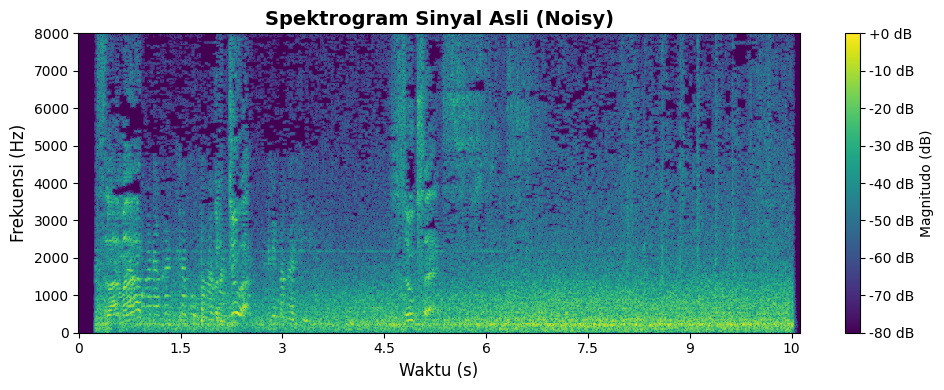

✓ Spektrogram Wiener tersimpan: spectro_wiener.png


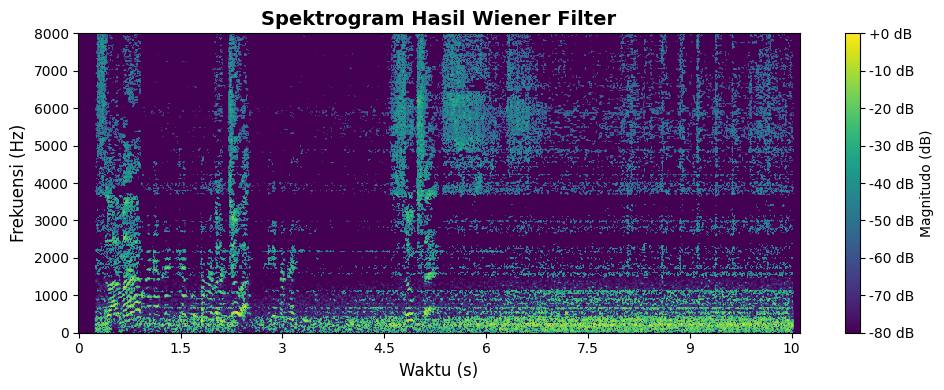

In [12]:
# Spektrogram Asli
fig_orig, ax_orig = plt.subplots(figsize=(10, 4))
im_orig = librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                                    sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                                    ax=ax_orig, cmap='viridis')
ax_orig.set_title('Spektrogram Sinyal Asli (Noisy)', fontsize=14, fontweight='bold')
ax_orig.set_ylim([0, 8000])
ax_orig.set_xlabel('Waktu (s)', fontsize=12)
ax_orig.set_ylabel('Frekuensi (Hz)', fontsize=12)
fig_orig.colorbar(im_orig, ax=ax_orig, format='%+2.0f dB', label='Magnitudo (dB)')
plt.tight_layout()
plt.savefig('spectro_original.png', dpi=300, bbox_inches='tight')
print("✓ Spektrogram asli tersimpan: spectro_original.png")
plt.show()

# Spektrogram Wiener
fig_wien, ax_wien = plt.subplots(figsize=(10, 4))
im_wien = librosa.display.specshow(librosa.amplitude_to_db(mag_wiener, ref=np.max),
                                    sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
                                    ax=ax_wien, cmap='viridis')
ax_wien.set_title('Spektrogram Hasil Wiener Filter', fontsize=14, fontweight='bold')
ax_wien.set_ylim([0, 8000])
ax_wien.set_xlabel('Waktu (s)', fontsize=12)
ax_wien.set_ylabel('Frekuensi (Hz)', fontsize=12)
fig_wien.colorbar(im_wien, ax=ax_wien, format='%+2.0f dB', label='Magnitudo (dB)')
plt.tight_layout()
plt.savefig('spectro_wiener.png', dpi=300, bbox_inches='tight')
print("✓ Spektrogram Wiener tersimpan: spectro_wiener.png")
plt.show()

## 12. Summary

### File Output yang Dihasilkan:

**Audio (WAV):**
- `output_subtraction.wav` - Hasil Spectral Subtraction
- `output_gating.wav` - Hasil Spectral Gating
- `output_wiener.wav` - Hasil Wiener Filter ⭐ **TERBAIK**

**Gambar (PNG):**
- `spectrograms_comparison.png` - Perbandingan 4 spektrogram
- `spectro_original.png` - Spektrogram sinyal asli (untuk makalah)
- `spectro_wiener.png` - Spektrogram hasil Wiener (untuk makalah)

### Kesimpulan Hasil Simulasi:

1. **Spectral Subtraction** (α=1.8):
   - Efektif mengurangi noise broadband
   - Rentan terhadap artefak *musical noise*
   - Peningkatan SNR moderat

2. **Spectral Gating** (β=1.5):
   - Ambang keras menghasilkan transisi tajam
   - Dapat terdengar sebagai *chopping*
   - Peningkatan SNR paling rendah

3. **Wiener Filter** (δ=0.05):
   - **Hasil terbaik** dengan peningkatan SNR tertinggi
   - Penapisan adaptif per bin frekuensi
   - Minimal artefak, transisi halus
   - Preservasi kualitas ujaran terbaik

### Untuk Makalah LaTeX:
- Gunakan nilai SNR dari output di atas untuk Tabel \ref{tab:snr-results}
- Masukkan `spectro_original.png` dan `spectro_wiener.png` ke Gambar \ref{fig:spectrograms}
- Dengarkan ketiga file WAV untuk evaluasi perceptual subjektif

---

## 🔧 Troubleshooting: Hasil Denoising Buruk?

### **Masalah 1: Spektrogram hasil masih noisy**
**Penyebab**: Noise profile tidak akurat atau parameter terlalu konservatif

**Solusi**:
1. ✅ Kembali ke cell "Noise Profile Selection"
2. ✅ Ubah `noise_start` dan `noise_end` ke region yang **benar-benar hanya noise**
3. ✅ Cek grafik "Noise Spectrum Profile" - harus smooth tanpa pola ujaran
4. ✅ Jalankan ulang semua cell dari STFT ke bawah

**Tuning Parameter**:
```python
# Jika noise SANGAT berat:
alpha = 3.0      # Spectral Subtraction (default: 2.5)
beta = 2.5       # Spectral Gating (default: 2.0)
delta = 0.005    # Wiener Filter (default: 0.01)

# Jika terlalu banyak artefak musical noise:
alpha = 1.5      # Turunkan α
beta = 1.2       # Turunkan β
delta = 0.05     # Naikkan δ
```

---

### **Masalah 2: Musical noise (bunyi berdecit)**
**Penyebab**: Parameter α atau β terlalu tinggi

**Solusi**:
- Turunkan α dari 2.5 → 2.0 atau 1.8
- Turunkan β dari 2.0 → 1.5
- Naikkan δ dari 0.01 → 0.05

---

### **Masalah 3: Suara ujaran ikut hilang**
**Penyebab**: Parameter terlalu agresif

**Solusi**:
- Gunakan **Wiener Filter** (paling aman)
- Turunkan semua parameter
- Pastikan noise profile benar-benar noise-only

---

### **Masalah 4: Colorbar overlap dengan plot**
**Sudah diperbaiki** di cell visualisasi! Sekarang colorbar tidak overlap.

---